In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
df = pd.read_excel(r'.\dataset\data_raw.xlsx')
df.y = df.y.astype('int32')

In [3]:
data = df[['ds', 'y']]
data = data.set_index('ds')

In [4]:
#Data check
data.tail()

,y
ds,
12/11/2019,4904485
13/11/2019,4588150
14/11/2019,4200848
15/11/2019,3678904
16/11/2019,1928384


In [5]:
#Take the last 30 days as a test dataset, take the rest for training
#30 days forecast
train, test = data[:-30], data[-30:]

In [6]:
#values between 0 and 1

scaler_train = MinMaxScaler()
scaler_train.fit(train)
train = scaler_train.transform(train)


In [16]:
#7 days forecast
train_7, test_7 = data[:-7], data[-7:]

#values between 0 and 1

scaler_train_7 = MinMaxScaler()
scaler_train_7.fit(train_7)
train_7 = scaler_train_7.transform(train_7)

#scaler_test_7 = MinMaxScaler()
#scaler_test_7.fit(test_7)
#test_7 = scaler_test_7.transform(test_7)

In [19]:
#7 days forecast

n_input = 7
n_features = 1
generator = TimeseriesGenerator(train_7, train_7, length=n_input, batch_size=6)
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=90, verbose=0)

In [20]:
model.save_weights("lstm_7_days_forecast_model.h5")

In [21]:
#Make predictions

pred_list = []

batch = train_7[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [22]:
df_predict = pd.DataFrame(scaler_train_7.inverse_transform(pred_list), index=df[-n_input:].index, columns=['Prediction'])
df_test = pd.concat([df,df_predict], axis=1)

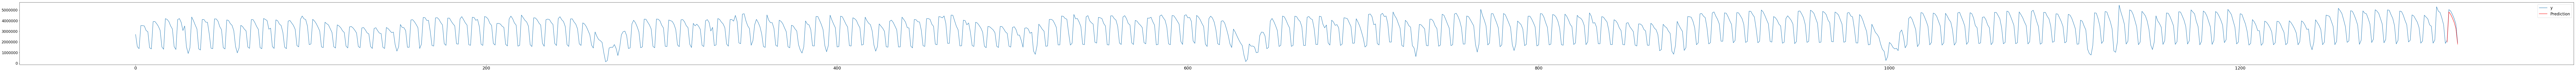

In [25]:
plt.figure(figsize=(200, 5))
plt.plot(df_test.index, df_test['y'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.savefig('7days.png')
plt.show()